## Finetuning CNNs [1]

A key observation from the learned weights of CNNs is that the initial layers learn a generic set of features (edges, gabor like) while the towards the classifier layer, the features become more specific to the given task. Hence one can use these pretrained features from say alexnet trained on ImageNet dataset as it is to a newer problem.

In this tutorial, we will learn how to train the network using transfer learning [2] to further improve these features to our task. We will use alexnet architecture and our problem is defined as fine grained classification of bird images. To restrict the size of the dataset we will use a subset of [Caltech-UCSD Birds-200-2011](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html) having only 10 classes.




In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
%matplotlib inline
import time
import copy
import os


DATA_ROOT = 'data'

print("torch version: %s"%torch.__version__)


torch version: 0.4.0


In [2]:
plt.ion()   # interactive mode

device = torch.device("cuda" )

#Using the standard dataloaders and transformers
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = os.path.join(DATA_ROOT,"CUB_10_Subset")

dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
         for x in ['train', 'val']}
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=4,
                                               shuffle=True, num_workers=4)
                for x in ['train', 'val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['train'].classes

/home/winter/deepLearning/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [3]:
#Printing the classes used in this tutorial
dsets['train'].classes

['003.Sooty_Albatross',
 '031.Black_billed_Cuckoo',
 '032.Mangrove_Cuckoo',
 '046.Gadwall',
 '069.Rufous_Hummingbird',
 '080.Green_Kingfisher',
 '125.Lincoln_Sparrow',
 '128.Seaside_Sparrow',
 '129.Song_Sparrow',
 '139.Scarlet_Tanager']

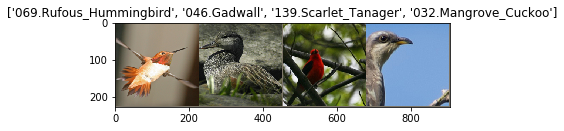

In [4]:
#Visualizing the datset images

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = np.abs(std * inp + mean)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dset_loaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[dset_classes[x] for x in classes])

### Transfer Learning
![transfer-all](images/transfer-all.png)

In [5]:
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=25):
    since = time.time()

    best_model = model
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dset_loaders[phase]:
                # get the inputs
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels).item()

            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects / dset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return best_model

######################################################################
# Learning rate scheduler
# ^^^^^^^^^^^^^^^^^^^^^^^
# Let's create our learning rate scheduler. We will exponentially
# decrease the learning rate once every few epochs.

def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer


######################################################################
# Visualizing the model predictions
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# Generic function to display predictions for a few images
#

def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dset_loaders['val']):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(dset_classes[labels.data[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return


#### AlexNet Architecture
![alexnet](images/alexnet.png)

#### Loading AlexNet

In [6]:
#Loading alexNet architecture
model_ft = models.alexnet(pretrained=False)

#Reading weights from pretrained model
model_ft.load_state_dict(torch.load(os.path.join(DATA_ROOT,'alexnet-owt-4df8aa71.pth')))

#Printing the architecture
print(model_ft)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

#### Re-Initializing the last layer

In [7]:
## Note: If you want to re-run this code, run the previous code (loading the alexnet) again

mod = list(model_ft.classifier.children())
#remove the last softmax layer
mod.pop()

#initialize a new layer with dimension (4096,10)
mod.append(torch.nn.Linear(4096, 10))
new_classifier = nn.Sequential(*mod)

model_ft.classifier = new_classifier
print(model_ft)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

Epoch 0/24
----------
LR is set to 0.001
train Loss: 0.4658 Acc: 0.4054
val Loss: 0.4065 Acc: 0.5918

Epoch 1/24
----------
train Loss: 0.2981 Acc: 0.6023
val Loss: 0.2810 Acc: 0.6939

Epoch 2/24
----------
train Loss: 0.2783 Acc: 0.6100
val Loss: 0.3149 Acc: 0.6939

Epoch 3/24
----------
train Loss: 0.2521 Acc: 0.6950
val Loss: 0.3486 Acc: 0.5918

Epoch 4/24
----------
train Loss: 0.2546 Acc: 0.6641
val Loss: 0.2047 Acc: 0.6939

Epoch 5/24
----------
train Loss: 0.2343 Acc: 0.6834
val Loss: 0.2196 Acc: 0.7347

Epoch 6/24
----------
train Loss: 0.2530 Acc: 0.6371
val Loss: 0.2835 Acc: 0.6327

Epoch 7/24
----------
LR is set to 0.0001
train Loss: 0.1890 Acc: 0.7452
val Loss: 0.2378 Acc: 0.7347

Epoch 8/24
----------
train Loss: 0.1294 Acc: 0.8456
val Loss: 0.2168 Acc: 0.7551

Epoch 9/24
----------
train Loss: 0.1046 Acc: 0.8340
val Loss: 0.2637 Acc: 0.7347

Epoch 10/24
----------
train Loss: 0.1104 Acc: 0.8378
val Loss: 0.2488 Acc: 0.7347

Epoch 11/24
----------
train Loss: 0.1181 Acc: 

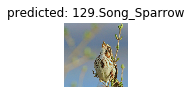

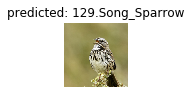

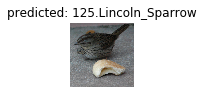

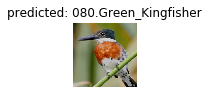

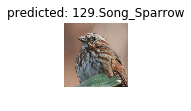

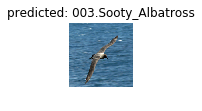

In [8]:
#Model would take around 1.6GB GPU memory
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss().cuda()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

visualize_model(model_ft)


#### ConvNet as fixed feature extractor
![transfer-freeze](images/transfer-freeze.png)
Here, we need to freeze all the network except the final layer. We need to set ``requires_grad == False`` to freeze the parameters so that the gradients are not computed in ``backward()``.

In [9]:
#Loading alexnet
model_ft = torchvision.models.alexnet(pretrained=False)
model_ft.load_state_dict(torch.load(os.path.join(DATA_ROOT,'alexnet-owt-4df8aa71.pth')))

#Setting all require_grad param to false for all learnable parameters
for param in model_ft.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
mod = list(model_ft.classifier.children())
mod.pop()

mod.append(torch.nn.Linear(4096, 10))
new_classifier = nn.Sequential(*mod)

model_ft.classifier = new_classifier

Epoch 0/24
----------
LR is set to 0.001
train Loss: 0.4556 Acc: 0.5444
val Loss: 0.3431 Acc: 0.6735

Epoch 1/24
----------
train Loss: 0.3453 Acc: 0.7027
val Loss: 0.5973 Acc: 0.7143

Epoch 2/24
----------
train Loss: 0.2302 Acc: 0.7954
val Loss: 0.2623 Acc: 0.8367

Epoch 3/24
----------
train Loss: 0.2627 Acc: 0.8185
val Loss: 0.4607 Acc: 0.7551

Epoch 4/24
----------
train Loss: 0.2208 Acc: 0.8340
val Loss: 0.3772 Acc: 0.7755

Epoch 5/24
----------
train Loss: 0.2126 Acc: 0.8494
val Loss: 0.3742 Acc: 0.8163

Epoch 6/24
----------
train Loss: 0.1739 Acc: 0.8494
val Loss: 0.3064 Acc: 0.7959

Epoch 7/24
----------
LR is set to 0.0001
train Loss: 0.1609 Acc: 0.8649
val Loss: 0.2467 Acc: 0.8571

Epoch 8/24
----------
train Loss: 0.0683 Acc: 0.9421
val Loss: 0.2721 Acc: 0.8163

Epoch 9/24
----------
train Loss: 0.0631 Acc: 0.9266
val Loss: 0.2678 Acc: 0.8367

Epoch 10/24
----------
train Loss: 0.1093 Acc: 0.9035
val Loss: 0.2296 Acc: 0.8571

Epoch 11/24
----------
train Loss: 0.0557 Acc: 

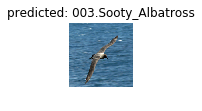

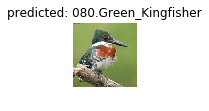

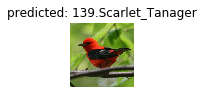

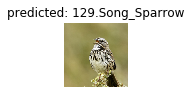

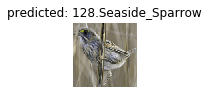

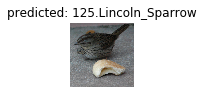

In [10]:
#Start fine tuning
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss().cuda()

# Observe that only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_ft.classifier[6].parameters(), lr=0.01, momentum=0.9)


model_ft = train_model(model_ft, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

######################################################################
#

visualize_model(model_ft)

plt.ioff()
plt.show()

### References
[1] Sasank Chilamkurthy, [Transfer Learning tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) <br>
[2] [CS231n Convolutional Neural Networks for Visual Recognition.](http://cs231n.github.io/transfer-learning/) <br>

